In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-09 10:14:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-09 10:14:05 (91.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [6]:
dataset = "/content/drive/MyDrive/aqua"
walk_through_dir(dataset);

There are 23 directories and 1 images in '/content/drive/MyDrive/aqua'.
There are 0 directories and 70 images in '/content/drive/MyDrive/aqua/clown tang'.
There are 0 directories and 71 images in '/content/drive/MyDrive/aqua/clown fish'.
There are 0 directories and 66 images in '/content/drive/MyDrive/aqua/green chromis'.
There are 0 directories and 70 images in '/content/drive/MyDrive/aqua/blue damsel fish'.
There are 0 directories and 73 images in '/content/drive/MyDrive/aqua/lion fish'.
There are 0 directories and 72 images in '/content/drive/MyDrive/aqua/moorish idol'.
There are 0 directories and 56 images in '/content/drive/MyDrive/aqua/mandarin fish'.
There are 0 directories and 67 images in '/content/drive/MyDrive/aqua/fire fish'.
There are 0 directories and 78 images in '/content/drive/MyDrive/aqua/gemmatum tang'.
There are 0 directories and 71 images in '/content/drive/MyDrive/aqua/emperor angelfish'.
There are 0 directories and 73 images in '/content/drive/MyDrive/aqua/achill

In [7]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

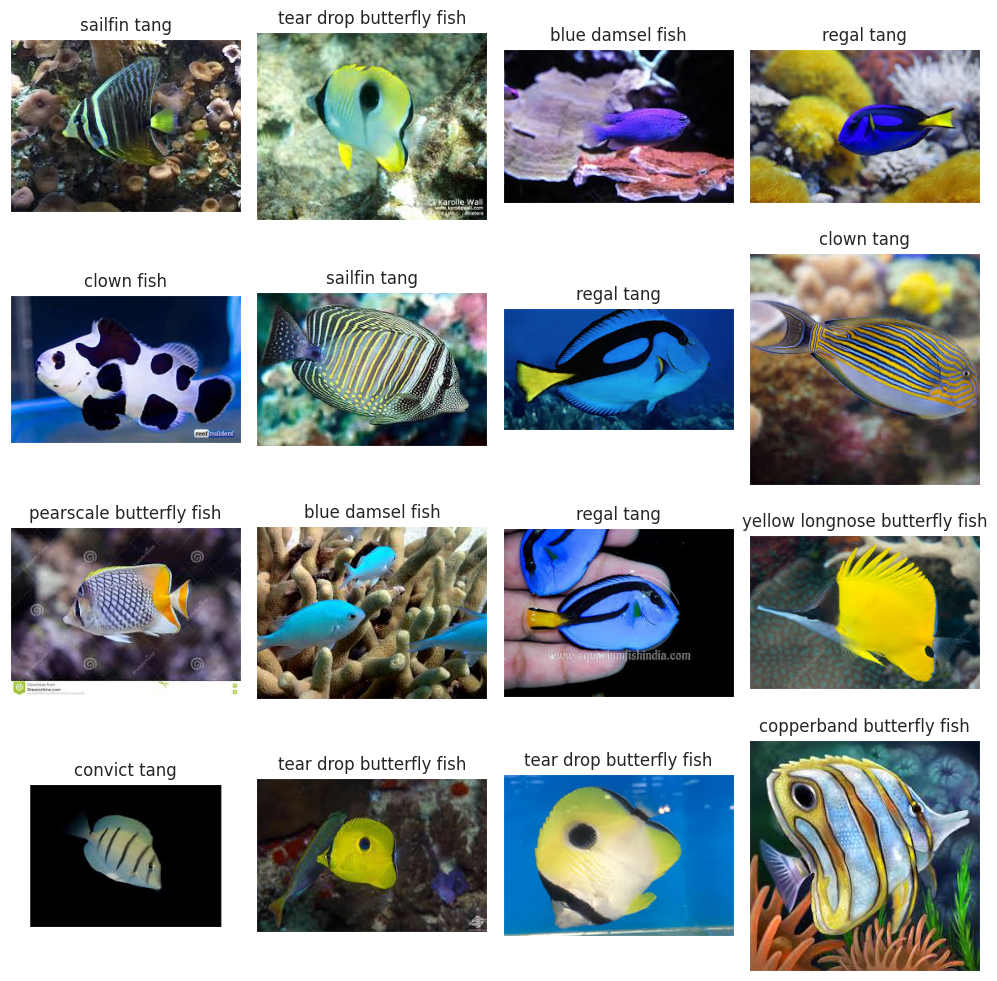

In [8]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

In [10]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training',
    
)


val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 797 validated image filenames belonging to 23 classes.
Found 199 validated image filenames belonging to 23 classes.
Found 250 validated image filenames belonging to 23 classes.


In [13]:
from tensorflow.keras.applications import ResNet50

from keras.models import Sequential
from keras.layers import Dense

In [14]:
model = Sequential()

model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))

model.add(Dense(23, activation='softmax'))

model.layers[0].trainable = False 

model.summary()

steps_per_epoch_training = len(train_images)
steps_per_epoch_validation = len(val_images)

94765736/94765736 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 23)                47127     
                                                                 
Total params: 23,634,839
Trainable params: 47,127
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [21]:
callbacks = myCallback()

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


fit_history = model.fit_generator(
    train_images,
    steps_per_epoch=steps_per_epoch_training,
    validation_steps=steps_per_epoch_validation,
    epochs=10,
    validation_data=val_images,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/10


<ipython-input-21-66ab7f7ae9b8>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


25/25 [==============================] - 8s 192ms/step - loss: 0.0924 - accuracy: 0.9975 - val_loss: 0.2758 - val_accuracy: 0.9196
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 1.0000
Reached 99.9% accuracy so cancelling training!
25/25 [==============================] - 5s 180ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.2186 - val_accuracy: 0.9548


In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.27667
Test Accuracy: 92.80%


In [23]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

8/8 [==============================] - 2s 110ms/step
The first 5 predictions: ['sailfin tang', 'gemmatum tang', 'regal tang', 'mandarin fish', 'moorish idol']


In [24]:
labels.items()

dict_items([(0, 'achilles tang'), (1, 'blue damsel fish'), (2, 'clown fish'), (3, 'clown tang'), (4, 'convict tang'), (5, 'copperband butterfly fish'), (6, 'emperor angelfish'), (7, 'fire fish'), (8, 'four stripped damsel fish'), (9, 'gemmatum tang'), (10, 'green chromis'), (11, 'latticed butterfly fish'), (12, 'lion fish'), (13, 'mandarin fish'), (14, 'moorish idol'), (15, 'pearscale butterfly fish'), (16, 'racoon butterfly fish'), (17, 'regal angelfish'), (18, 'regal tang'), (19, 'sailfin tang'), (20, 'six bar angelfish'), (21, 'tear drop butterfly fish'), (22, 'yellow longnose butterfly fish')])

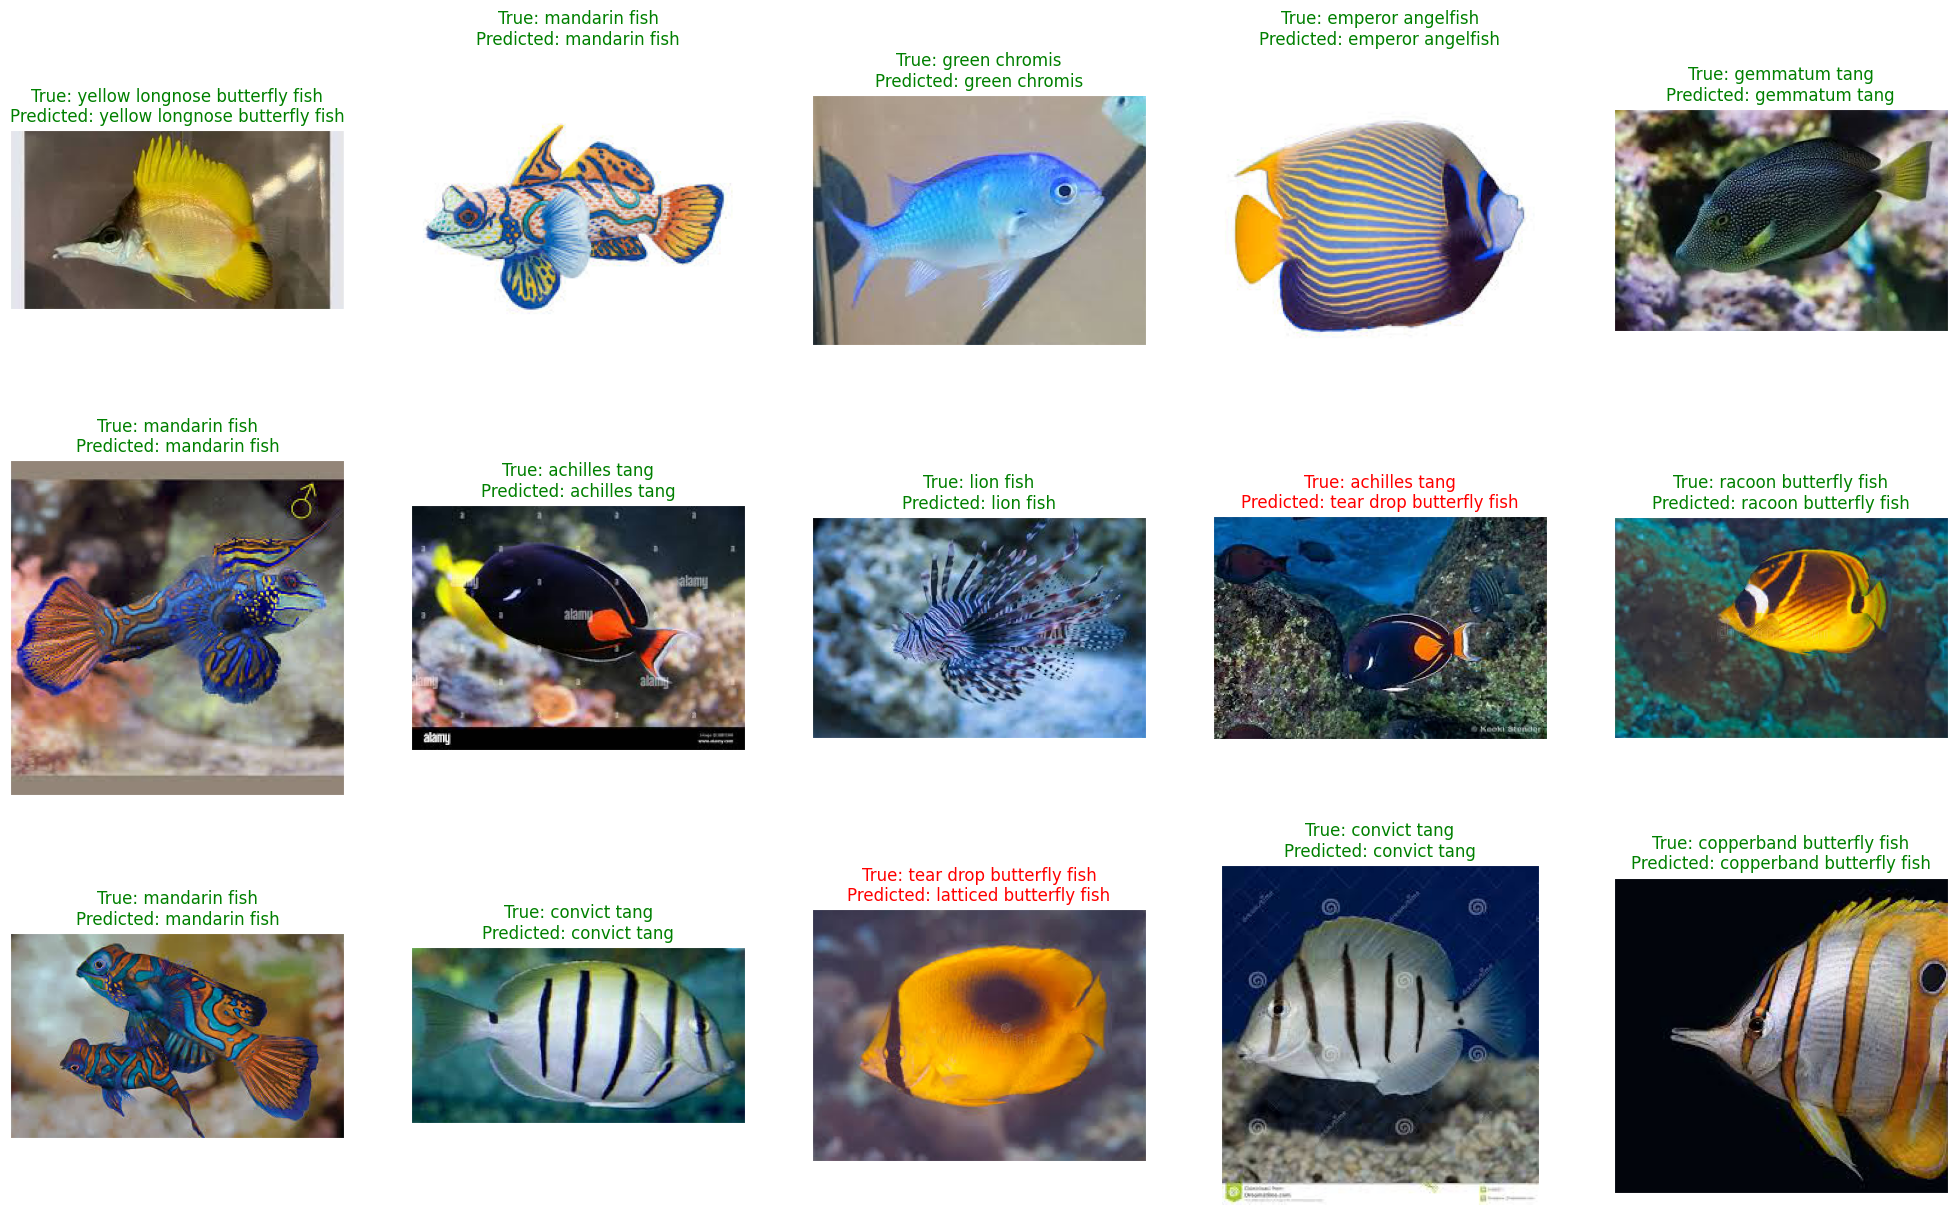

<Figure size 640x480 with 0 Axes>

In [25]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [28]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [29]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Prepare the new image
new_image_path = "/content/drive/MyDrive/tit/images (4).jpeg"

# Load and preprocess the new image
new_image = load_img(new_image_path, target_size=TARGET_SIZE)
new_image = img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = preprocess_input(new_image)

# Predict the new image
predictions = model.predict(new_image)
predicted_label_index = np.argmax(predictions)
predicted_label_index


1/1 [==============================] - 1s 1s/step


7

In [32]:
labels

{0: 'achilles tang',
 1: 'blue damsel fish',
 2: 'clown fish',
 3: 'clown tang',
 4: 'convict tang',
 5: 'copperband butterfly fish',
 6: 'emperor angelfish',
 7: 'fire fish',
 8: 'four stripped damsel fish',
 9: 'gemmatum tang',
 10: 'green chromis',
 11: 'latticed butterfly fish',
 12: 'lion fish',
 13: 'mandarin fish',
 14: 'moorish idol',
 15: 'pearscale butterfly fish',
 16: 'racoon butterfly fish',
 17: 'regal angelfish',
 18: 'regal tang',
 19: 'sailfin tang',
 20: 'six bar angelfish',
 21: 'tear drop butterfly fish',
 22: 'yellow longnose butterfly fish'}

In [33]:
labels[predicted_label_index]

'fire fish'

In [34]:
model.save("model.hdf5")